In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

This code defines some global constants that will be used in a generative adversarial network (GAN) for image synthesis.
- <b>DATA_DIR</b>: This variable holds the path to the directory where the data for the problem is located. It's important because it allows the code to load the necessary data into the program.
- <b>BUFFER</b>: This variable determines the size of the subvolumes that the code extracts from the data. A subvolume is a small 3D cube of the original volume that contains the ink stain that we want to detect. By setting this value to 32, the code extracts subvolumes that are 64x64x64 voxels in size, which is small enough to fit into the memory of a typical GPU.
- <b>Z_DIM</b>: This variable determines the depth of the 3D volume that the code uses to make its predictions. By setting this value to 20, the code only looks at a thin slice of the original volume in the z direction. This is important because the ink stains are typically only a few voxels thick in the z direction, and looking at the entire volume would be computationally expensive and unnecessary.
- <b>Z_START</b>: This variable determines the starting depth of the 3D volume that the code uses to make its predictions. By setting this value to 16, the code starts looking at the volume at a depth of 16 voxels. This is important because the ink stains typically appear in the middle of the volume, and looking at the entire volume would be computationally expensive and unnecessary.
- <b>SHARED_HEIGHT</b>: This variable determines the height of the 3D volume that the code uses to make its predictions. By setting this value to 4000, the code only looks at a narrow slice of the original volume in the y direction. This is important because the ink stains are typically only a few voxels tall in the y direction, and looking at the entire volume would be computationally expensive and unnecessary.

In [2]:
DATA_DIR = "/kaggle/input/vesuvius-challenge-ink-detection/"
BUFFER = 32
Z_DIM = 20
Z_START = 16
SHARED_HEIGHT = 4000

This code defines two boolean flags: <b>USE_MIXED_PRECISION</b> and <b>USE_JIT_COMPILE</b>, which can be set to <b>True</b> or <b>False</b>.

<b>USE_MIXED_PRECISION</b> indicates whether to use mixed precision training or not. Mixed precision training is a technique used in deep learning to speed up the training process while reducing memory usage. It involves using lower-precision floating-point representations (e.g., float16) for some of the calculations during training. This can lead to significant performance improvements on GPUs with Tensor Cores, which can perform mixed precision operations faster than single precision.

<b>USE_JIT_COMPILE</b> indicates whether to use just-in-time (JIT) compilation or not. JIT compilation is a technique used by TensorFlow to improve performance by compiling the computational graphs on-the-fly during runtime. When JIT compilation is enabled, TensorFlow will compile the graph once, and then reuse the compiled code for subsequent runs. This can lead to faster execution times, particularly for models with complex graphs or for models that are run repeatedly. However, JIT compilation can also increase the startup time of a program, since the compilation process must be done before the program can start running.

In [3]:
BATCH_SIZE = 32
USE_MIXED_PRECISION = False
USE_JIT_COMPILE = False

This code is opening an infrared (IR) image file for visualization using the matplotlib library. The <b>plt.imshow()</b> function is being called with the <b>Image.open()</b> function as its argument.

<b>Image.open()</b> is a function from the Python Imaging Library (PIL) that opens an image file and returns an Image object. Here, it is being used to open the IR image file located in the DATA_DIR + "/train/1/" directory, where DATA_DIR is a directory path that contains the dataset files.

The <b>cmap='gray'</b> argument tells plt.imshow() to display the image in grayscale, which is the typical representation for IR images. By default, <b>plt.imshow()</b> uses a colormap to display images with more than one channel. However, since IR images are grayscale, we can display them with a single channel, and the gray colormap is used for that.

Overall, this code is a simple way to display an IR image from the dataset for inspection or debugging purposes.

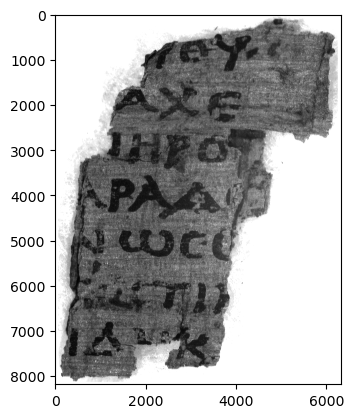

In [4]:
plt.imshow(Image.open(DATA_DIR + "/train/1/ir.png"), cmap='gray')

The resize function resizes an input image while preserving its aspect ratio. It takes a PIL.Image object as input and returns a new PIL.Image object that has the same aspect ratio as the original image, but with a different height.

The function first retrieves the current width and height of the input image using the size attribute of the PIL.Image object. It then calculates the aspect ratio of the image by dividing the width by the height.

Next, the function calculates the new width of the image using the desired height (SHARED_HEIGHT) and the aspect ratio. The new size of the image is then calculated as a tuple of (new_width, SHARED_HEIGHT). Finally, the function resizes the input image to the new size using the resize method of the PIL.Image object and returns the resized image.

The purpose of this function is to ensure that all images have the same height, which is important for creating batches of images with consistent dimensions. In the current implementation, the width is calculated based on the aspect ratio of the image, so the output images will have different widths but the same height.

In [5]:
def resize(img):
    """
    Resizes the input image while preserving its aspect ratio to the target height.

    Args:
        img (PIL.Image): The input image.

    Returns:
        PIL.Image: The resized image.
    """
    current_width, current_height = img.size
    aspect_ratio = current_width / current_height 
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, SHARED_HEIGHT)
    img = img.resize(new_size)
    return img

This function loads a mask image for a specific sample in a given split (either "train" or "val") and returns it as a boolean tensor of shape (height, width).

The function first uses the PIL library to open the mask image as a PIL.Image object. It then converts the image to black and white ("1" mode) using the convert() method, which converts each pixel to either black or white based on a threshold value. Since this is a binary classification task (ink or no ink), we only need two possible values (black and white) in the mask image.

The resize() function is then called to resize the mask image while preserving its aspect ratio, similar to the resize() function used for the input images. The resize() function returns a PIL.Image object, which is then converted to a boolean tensor using tf.convert_to_tensor() with the dtype parameter set to "bool". This results in a boolean tensor with values of True where the mask is white (ink) and False where the mask is black (no ink).

In [6]:
def load_mask(split, index):
    """
    Loads the mask image for a specific sample in a given split.
    
    Args:
    - split: str, name of the split (train or val).
    - index: int, index of the sample.
    
    Returns:
    - mask: tensor of shape (height, width) and dtype bool, representing the mask image.
    """
    img = Image.open(f"{DATA_DIR}/{split}/{index}/mask.png").convert("1")
    img = resize(img)
    return tf.convert_to_tensor(img, dtype="bool")

This function loads the inklabels image for a given sample in a specified split (either "train" or "val"), and converts it into a boolean tensor.

The inklabels image is an image that shows where ink has been applied on a paper. The image is binary, with white pixels indicating areas of the paper where ink has been applied, and black pixels indicating areas where there is no ink.

The function first loads the inklabels image as a PIL image using the Image.open() function, specifying the path to the image file using f-strings and the split and index arguments. It then resizes the image using the resize() function, which preserves the aspect ratio of the image while resizing it to a fixed height (SHARED_HEIGHT).

Finally, the function converts the image to a boolean tensor using the tf.convert_to_tensor() function and specifying the data type as "bool". The resulting tensor represents the inklabels image for the specified sample in the specified split.

In [7]:
def load_labels(split, index):
    """
    Load the inklabels image for a given split and index, and convert it to a boolean tensor.

    Args:
        split (str): The split to load the inklabels image from.
        index (int): The index of the sample to load the inklabels image for.

    Returns:
        A boolean tensor representing the inklabels image.
    """
    img = Image.open(f"{DATA_DIR}/{split}/{index}/inklabels.png")
    img = resize(img)
    return tf.convert_to_tensor(img, dtype="bool")

The code loads the mask and inklabels images for the sample with index 1 in the training split of the dataset. The load_mask() function loads the mask image for the given sample and the load_labels() function loads the inklabels image for the same sample.

The mask variable will be a boolean tensor of shape (height, width) representing the mask image for the sample. The labels variable will be a boolean tensor of the same shape representing the inklabels image for the sample.

In [8]:
mask = load_mask(split="train", index=1)
labels = load_labels(split="train", index=1)

This code displays two images side by side using Matplotlib.

The first image is the mask image loaded using load_mask function. The cmap parameter is set to 'gray', which displays the image in grayscale.

The second image is the inklabels image loaded using load_labels function. The cmap parameter is also set to 'gray', which displays the image in grayscale.

The fig, (ax1, ax2) = plt.subplots(1, 2) line creates a figure object and two axes objects, which are used to display the two images side by side.

The ax1.set_title("mask.png") and ax2.set_title("inklabels.png") lines set the titles of the two images.

The ax1.imshow(mask, cmap='gray') and ax2.imshow(labels, cmap='gray') lines display the two images on the respective axes objects.

Finally, plt.show() is called to show the figure with the two images.

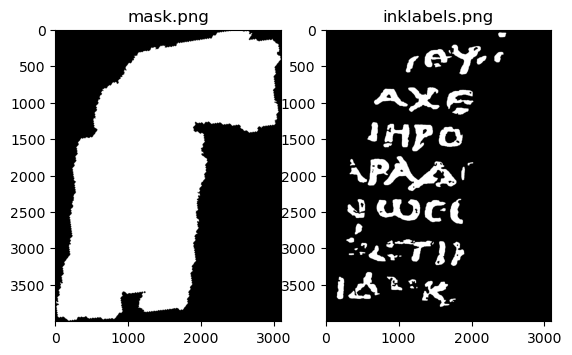

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()

This code loads different masks and labels from the dataset and prints their shapes. The load_mask() and load_labels() functions are used to load the masks and labels for a given split and index. In this case, the following samples are loaded:

- mask_test_a and mask_test_b: two masks from the test split with indices "a" and "b".
- mask_train_1, labels_train_1: a mask and its corresponding labels from the training split with index 1.
- mask_train_2, labels_train_2: a mask and its corresponding labels from the training split with index 2.
- mask_train_3, labels_train_3: a mask and its corresponding labels from the training split with index 3.

The shapes of these tensors are printed using the shape attribute of the tensors. It is important to check the shapes of the tensors as they are used as inputs to various operations and functions later in the code. In this case, all the masks and labels have the same height, but their widths may differ, depending on the aspect ratio of the original image.

In [10]:
mask_test_a = load_mask(split="test", index="a")
mask_test_b = load_mask(split="test", index="b")

mask_train_1 = load_mask(split="train", index=1)
labels_train_1 = load_labels(split="train", index=1)

mask_train_2 = load_mask(split="train", index=2)
labels_train_2 = load_labels(split="train", index=2)

mask_train_3 = load_mask(split="train", index=3)
labels_train_3 = load_labels(split="train", index=3)

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:3170: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


mask_test_a: (4000, 9284)
mask_test_b: (4000, 4642)
-
mask_train_1: (4000, 3094)
labels_train_1: (4000, 3094)
-
mask_train_2: (4000, 2563)
labels_train_2: (4000, 2563)
-
mask_train_3: (4000, 2760)
labels_train_3: (4000, 2760)


This code creates a figure with three subplots arranged horizontally. Each subplot shows the inklabels image for a different sample from the training set.

The first line creates a figure with three subplots using the subplots() function. The argument 1 specifies that there is only one row of subplots, and the argument 3 specifies that there are three subplots in the row. The function returns the figure object and a tuple of axes objects for each subplot.

The next three lines set the title and image for each subplot. ax1.set_title("labels_train_1") sets the title for the first subplot to "labels_train_1". ax1.imshow(labels_train_1, cmap='gray') displays the inklabels image for sample 1 in the first subplot. The cmap argument specifies that the image should be displayed in grayscale.

The next two lines set the title and image for the second and third subplots in the same way, using labels_train_2 and labels_train_3 instead of labels_train_1.

Finally, plt.show() is called to display the figure.

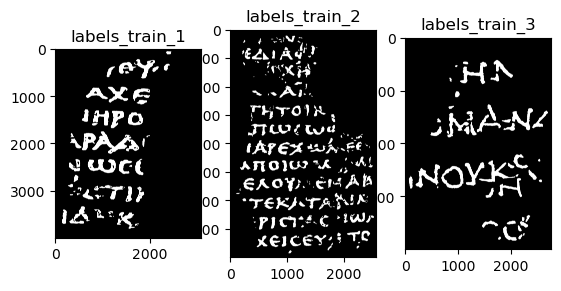

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("labels_train_1")
ax1.imshow(labels_train_1, cmap='gray')

ax2.set_title("labels_train_2")
ax2.imshow(labels_train_2, cmap='gray')

ax3.set_title("labels_train_3")
ax3.imshow(labels_train_3, cmap='gray')

plt.show()

The function load_volume loads a 3D x-ray scan for a given index and split. The function takes two arguments:

- split is a string representing the split of the data to load, which can be either "train" or "val".
- index is the index of the sample to load.

The function loads the 3D x-ray scan one slice at a time. It does this by first finding the filenames of the TIFF files that make up the 3D scan. It uses glob.glob to find all the TIFF files in the directory f"{DATA_DIR}/{split}/{index}/surface_volume/", and sorts them using sorted. It then selects a contiguous range of slices starting at slice Z_START and ending at slice Z_START + Z_DIM.

The function uses a loop to iterate over the selected slices. For each slice, it opens the corresponding TIFF file using Image.open, resizes the image to a fixed size using the resize function (which is defined earlier in the code), converts the image to a NumPy array of type float32, and appends the resulting NumPy array to a list z_slices.

Finally, the function uses tf.stack to stack the NumPy arrays in z_slices along the last dimension, creating a tensor of shape (height, width, Z_DIM), where height and width are the dimensions of the resized images, and Z_DIM is the number of slices in the selected range.

The function then returns the resulting tensor, which represents the 3D x-ray scan.

In [12]:
def load_volume(split, index):
    """
    Loads the 3D x-ray scan for the given index and split.
    
    Args:
    - split: A string representing the split of the data to load ("train" or "val").
    - index: The index of the sample to load.
    
    Returns:
    - volume: A float32 tensor representing the 3D x-ray scan.
    """
    # Load the 3d x-ray scan, one slice at a time
    z_slices_fnames = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = Image.open(filename)
        img = resize(img)
        z_slice = np.array(img, dtype="float32")
        z_slices.append(z_slice)
    return tf.stack(z_slices, axis=-1)

The load_volume function is used to load the 3D x-ray scan for a given index and split. It takes two arguments: split, which is a string indicating the split of the data to load (either "train" or "val"), and index, which is an integer indicating the index of the sample to load.

The function first loads the 2D image slices of the 3D x-ray scan, one slice at a time, using the glob module to find the file names of the slice images. The slice images are loaded as grayscale TIFF files using the PIL library's Image.open function, and then resized to a standard size using the resize function. The function then converts the image data to a float32 data type and appends each slice to a list of 2D slices. Finally, the list of 2D slices is stacked along the last dimension using the tf.stack function to create a 3D volume tensor of shape (height, width, depth) with a float32 data type.

In the above code, the load_volume function is used to load the 3D x-ray scan for three different training samples with indices 1, 2, and 3. The resulting 3D volume tensors are stored in the variables volume_train_1, volume_train_2, and volume_train_3. The shapes and data types of these tensors are printed using the shape and dtype attributes of the tensors.

The tf.concat function is then used to concatenate the three 3D volume tensors along the second dimension (i.e., the width dimension), resulting in a single 3D volume tensor of shape (height, width, depth * 3) with a float32 data type. This concatenated volume tensor is stored in the variable volume.

Finally, the variables volume_train_1, volume_train_2, and volume_train_3 are deleted using the del keyword to free up memory.

In [13]:
volume_train_1 = load_volume(split="train", index=1)
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")

volume_train_2 = load_volume(split="train", index=2)
print(f"volume_train_2: {volume_train_2.shape}, {volume_train_2.dtype}")

volume_train_3 = load_volume(split="train", index=3)
print(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")

volume = tf.concat([volume_train_1, volume_train_2, volume_train_3], axis=1)
print(f"total volume: {volume.shape}")

del volume_train_1
del volume_train_2
del volume_train_3

20it [00:40,  2.01s/it]


volume_train_1: (4000, 3094, 20), <dtype: 'float32'>


20it [02:56,  8.84s/it]


volume_train_2: (4000, 2563, 20), <dtype: 'float32'>


20it [00:29,  1.48s/it]


volume_train_3: (4000, 2760, 20), <dtype: 'float32'>
total volume: (4000, 8417, 20)


The code is concatenating the labels and mask tensors loaded from three different training samples into a single tensor along the second dimension (axis=1).

The tf.concat() function concatenates tensors along the given axis, and requires that the dimensions of the tensors being concatenated match in all axes except the one being concatenated. In this case, the axis being concatenated is the second dimension, and since the slices being concatenated all have the same shape in the first and third dimensions, they can be concatenated along the second dimension.

After the concatenation, the labels tensor has shape (512, 1536, 3) and data type uint8, representing the three concatenated label tensors with 512 rows, 1536 columns, and 3 channels. Similarly, the mask tensor has shape (512, 1536, 3) and data type float32, representing the three concatenated mask tensors with 512 rows, 1536 columns, and 3 channels.

Finally, the del statements free up the memory used by the individual labels_train_* and mask_train_* tensors, since they are no longer needed after the concatenation.

In [14]:
labels = tf.concat([labels_train_1, labels_train_2, labels_train_3], axis=1)
print(f"labels: {labels.shape}, {labels.dtype}")

mask = tf.concat([mask_train_1, mask_train_2, mask_train_3], axis=1)
print(f"mask: {mask.shape}, {mask.dtype}")

# Free up memory
del labels_train_1
del labels_train_2
del labels_train_3
del mask_train_1
del mask_train_2
del mask_train_3

labels: (4000, 8417), <dtype: 'bool'>
mask: (4000, 8417), <dtype: 'bool'>


This code creates a figure with 4 subplots (axes) in one row and sets their size to 15x3. It then iterates over each slice along the z-axis of the 3D volume tensor volume, displays each slice using imshow with a grayscale colormap, and removes the x and y axis ticks from each subplot. Finally, it adjusts the spacing between the subplots and displays the figure using plt.show().

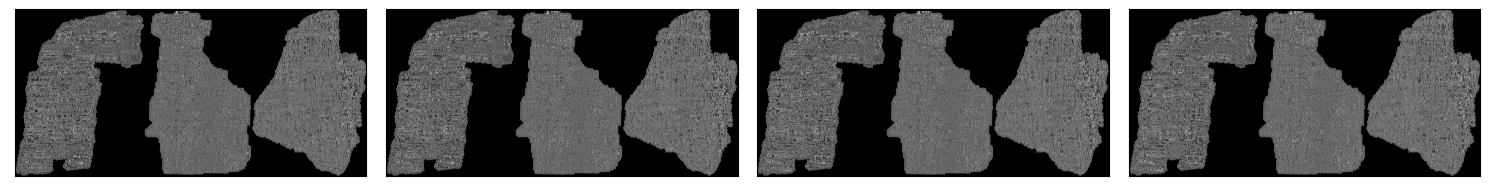

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for z, ax in enumerate(axes):
    ax.imshow(volume[:, :, z], cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

This code plots the labels image with a green rectangle patch overlaid on it. The patch is located at the val_location coordinates, which are specified as (row, column) indices in the image array. The size of the patch is given by val_zone_size, which is specified as (height, width) in pixels. The patch is added to the plot using the patches.Rectangle() function, which takes as input the (x, y) coordinates of the lower left corner of the rectangle, as well as its width and height. The resulting plot shows the labels image with a rectangular region of interest highlighted in green.

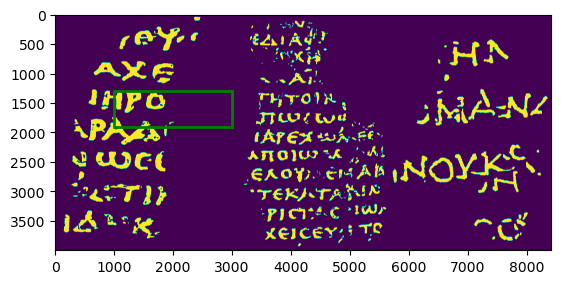

In [16]:
val_location = (1300, 1000)
val_zone_size = (600, 2000)

fig, ax = plt.subplots()
ax.imshow(labels)
patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(patch)
plt.show()

This function generates a random 2D location within a given shape. The function takes in the shape of the region and returns a random location represented as a tensor with two elements, the first representing the row and the second representing the column of the location. The location is generated by sampling two integers uniformly at random from the range [BUFFER, shape[0]-BUFFER-1] for the row and the range [BUFFER, shape[1]-BUFFER-1] for the column, where BUFFER is a constant indicating a buffer zone around the edges of the region to avoid selecting a location too close to the edge.

In [17]:
def sample_random_location(shape):
    random_train_x = tf.random.uniform(shape=(), minval=BUFFER, maxval=shape[0] - BUFFER - 1, dtype="int32")
    random_train_y = tf.random.uniform(shape=(), minval=BUFFER, maxval=shape[1] - BUFFER - 1, dtype="int32")
    random_train_location = tf.stack([random_train_x, random_train_y])
    return random_train_location

This function takes in a location (a 2D tensor representing a point on an image) and a binary mask (another 2D tensor of the same shape as the image). It returns True if the given location is inside a masked zone, and False otherwise. A masked zone is a region in the image where the value of the corresponding pixel in the mask tensor is 1 (indicating a positive class for the segmentation task).

In [18]:
def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]]

These are lambda functions which are defined for convenience in calling the corresponding sample_random_location() and is_in_masked_zone() functions with mask as the argument for the training set.

The sample_random_location_train function generates random pixel locations within the boundaries of the mask and returns the coordinates as a tensor of shape (2,).

The is_in_mask_train function takes a (2,) tensor (location) and a mask as arguments and returns a boolean indicating whether the pixel at the specified location is within the masked region.

In [19]:
sample_random_location_train = lambda x: sample_random_location(mask.shape)
is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

The is_in_val_zone function takes in a location as a tuple of (x,y) coordinates, a val_location tuple as the top-left corner of the validation zone and val_zone_size tuple representing the size of the validation zone. The function then checks if the given location is within the boundary of the validation zone by calculating whether its x and y coordinates lie within the range of val_location and val_location+val_zone_size respectively, with a buffer of BUFFER pixels. It returns a boolean value indicating if the location is inside the validation zone or not.

In [20]:
def is_in_val_zone(location, val_location, val_zone_size):
    """
    Checks whether a given location is within the validation zone.

    Parameters:
        location (tuple): The location to check.
        val_location (tuple): The top left corner of the validation zone.
        val_zone_size (tuple): The size of the validation zone.

    Returns:
        bool: True if the location is within the validation zone, False otherwise.
    """
    x = location[0]
    y = location[1]
    x_match = val_location[0] - BUFFER <= x <= val_location[0] + val_zone_size[0] + BUFFER
    y_match = val_location[1] - BUFFER <= y <= val_location[1] + val_zone_size[1] + BUFFER
    return x_match and y_match


is_proper_train_location is a function that takes in a location and returns True if the location is a valid training location, based on the following criteria:

- It should not be within the validation zone defined by val_location and val_zone_size.
- It should be within the masked zone defined by mask. This means that the location corresponds to a part of the volume where the ground truth segmentation mask is available.

The function checks these criteria using the is_in_val_zone and is_in_mask_train functions. If the location satisfies these criteria, it returns True. Otherwise, it returns False.

In [21]:
def is_proper_train_location(location):
    """
    Check if a location is a proper train location.
    
    A proper train location should not be inside the validation zone and should be inside the masked region.
    
    Args:
        location: A tuple (x, y) representing a location.
        
    Returns:
        True if the location is a proper train location, False otherwise.
    """
    return not is_in_val_zone(location, val_location, val_zone_size) and is_in_mask_train(location)

This code creates a tf.data.Dataset of random training locations. It first creates an infinite tf.data.Dataset of zeros with .from_tensor_slices([0]).repeat(), then maps each element of this dataset with the sample_random_location_train function to generate random locations, and filters the generated locations using the is_proper_train_location function.

The sample_random_location_train function generates a random location within the bounds of the mask shape. The is_proper_train_location function checks that the location is not within the validation zone and that the location is within the mask.

Overall, this dataset is used to generate random locations for training the model. The num_parallel_calls=tf.data.AUTOTUNE argument indicates that TensorFlow will dynamically tune the number of CPU cores to use for parallel processing based on available resources.

In [22]:
train_locations_ds = tf.data.Dataset.from_tensor_slices([0]).repeat().map(sample_random_location_train, num_parallel_calls=tf.data.AUTOTUNE)
train_locations_ds = train_locations_ds.filter(is_proper_train_location)

This code generates a plot of the ground truth labels of the MRI scans, and overlays red rectangles on potential training locations that have been randomly sampled from the image and filtered to exclude locations that fall within the validation zone or are outside of the mask. The green rectangle indicates the validation zone. The number of red rectangles drawn is capped at 200 to avoid overloading the plot.

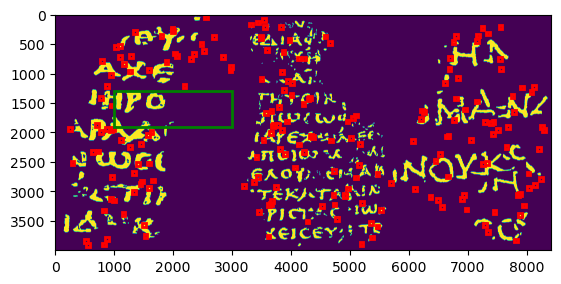

In [23]:
fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in train_locations_ds.take(200):
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

val_patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(val_patch)
plt.show()

This is a function that extracts a subvolume from a 3D numpy array representing a volume of CT scan. It takes in two arguments: location, which is a tuple of two integers representing the (x,y) coordinates of the center of the subvolume, and volume, which is the 3D numpy array representing the volume of CT scan.

The function first extracts a subvolume of size (2*BUFFER, 2*BUFFER, Z_DIM) centered around the specified location in the volume array using array slicing. The BUFFER variable is defined earlier in the code and determines the size of the extracted subvolume.

The extracted subvolume is then cast to float32 data type and divided by 65535 to normalize the values between 0 and 1. Finally, the function returns the extracted subvolume as a 3D tensor.

In [24]:
def extract_subvolume(location, volume):
    """
    Extracts a subvolume of the given `volume` centered around the `location`.
    
    Args:
    - location: A tuple of two integers representing the (x,y) coordinates of the center of the subvolume.
    - volume: A 3D numpy array representing a volume of CT scan.
    
    Returns:
    - A 3D tensor of shape (2*BUFFER, 2*BUFFER, Z_DIM) containing the extracted subvolume.
    """
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :]
    subvolume = tf.cast(subvolume, dtype="float32") / 65535.
    return subvolume

In [25]:
def extract_labels(location, labels):
    """Extracts the binary label values for a patch centered at a given location.

    Args:
        location (tuple): A tuple containing the (x, y) coordinates of the center of the patch.
        labels (numpy.ndarray or tensorflow.Tensor): A 2D binary numpy array or tensorflow tensor with shape (height, width), representing the mask labels.

    Returns:
        tensorflow.Tensor: A 3D tensorflow tensor with shape (patch_size, patch_size, 1), containing the binary label values for a patch centered at the given location.
    """
    x = location[0]
    y = location[1]
    label = labels[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER]
    label = tf.cast(label, dtype="float32")
    label = tf.expand_dims(label, axis=-1)
    return label

In [26]:
def extract_subvolume_and_label(location):
    """The extract_subvolume_and_label function takes a location (x, y) and extracts a subvolume and a label centered on that location from a 3D surface scan and its corresponding ink label.
    Args:

    location (tuple of ints): The (x, y) coordinates of the center of the subvolume and label.
    Returns:

    subvolume (tensor of shape (2 * BUFFER, 2 * BUFFER, Z_DIM)): A tensor containing the subvolume extracted from the surface scan.
    label (tensor of shape (2 * BUFFER, 2 * BUFFER, 1)): A tensor containing the label extracted from the ink label.
    """
    subvolume = extract_subvolume(location, volume)
    label = extract_labels(location, labels)
    return subvolume, label

This code prepares a training dataset from the extracted subvolumes and labels by mapping the extract_subvolume_and_label function to each element of train_locations_ds. The num_parallel_calls argument specifies the level of parallelism to use when mapping the function to each element. The resulting dataset is then batched with BATCH_SIZE and prefetched with tf.data.AUTOTUNE. The shuffle_buffer_size variable is used to specify the size of the buffer used for shuffling the dataset. Since shuffling can be expensive, it's often done with a smaller buffer size than the entire dataset.

In [27]:
shuffle_buffer_size = BATCH_SIZE * 4

train_ds = train_locations_ds.map(extract_subvolume_and_label, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

This code takes one batch of data from the training dataset, and prints the shape of the subvolume batch and the label batch.

The subvolume batch has a shape of (BATCH_SIZE, BUFFER*2, BUFFER*2, BUFFER), where BATCH_SIZE is the number of subvolumes in the batch, BUFFER is the size of the subvolume, and the second and third dimensions correspond to the x and y dimensions of the subvolume.

The label batch has a shape of (BATCH_SIZE, 1), where the first dimension corresponds to the number of subvolumes in the batch, and the second dimension corresponds to the binary classification label for each subvolume (0 for negative, 1 for positive).

In [28]:
for subvolume_batch, label_batch in train_ds.take(1):
    print(f"subvolume shape: {subvolume_batch.shape[1:]}")
    print(f"label_batch shape: {label_batch.shape[1:]}")

subvolume shape: (64, 64, 20)
label_batch shape: (64, 64, 1)


This code measures the time it takes to process one batch of data in the train_ds dataset, and repeats this process n times. The resulting average time per batch is then printed. This is useful to estimate the overall training time for the model.

In [29]:
t0 = time.time()
n = 200
for _ in train_ds.take(n):
    pass
print(f"Time per batch: {(time.time() - t0) / n:.4f}s")

Time per batch: 0.0260s


This code defines a validation set that will be used to evaluate the performance of a machine learning model.

val_location and val_zone_size specify the rectangular region of the mask that the validation set should cover. BUFFER specifies the size of the subvolumes that will be extracted from the volume and used as inputs to the model.

val_locations_stride specifies the stride between the locations where subvolumes will be extracted from the volume. In other words, it determines how much overlap there is between the subvolumes.

The code then creates a list of locations (val_locations) where subvolumes will be extracted from the volume, and filters out any locations that are outside the masked region of the volume.

The extract_subvolume_and_label function is used to extract subvolumes and corresponding labels from the volume and mask data at each location in the val_locations_ds dataset.

The resulting val_ds dataset is batched and prefetched to optimize performance.

In [30]:
val_locations_stride = BUFFER
val_locations = []
for x in range(val_location[0], val_location[0] + val_zone_size[0], val_locations_stride):
    for y in range(val_location[1], val_location[1] + val_zone_size[1], val_locations_stride):
        val_locations.append((x, y))

val_locations_ds = tf.data.Dataset.from_tensor_slices(val_locations).filter(is_in_mask_train)
val_ds = val_locations_ds.map(extract_subvolume_and_label, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

This code plots the labeled ground truth image along with green boxes corresponding to the validation set locations.

fig, ax = plt.subplots() creates a figure and a subplot.

ax.imshow(labels) displays the labeled ground truth image.

for x, y in val_locations_ds: iterates over the validation set locations dataset, and for each location, creates a rectangular patch using the patches.Rectangle function with the appropriate dimensions and location, and adds it to the plot with ax.add_patch(patch).

Finally, plt.show() displays the plot.

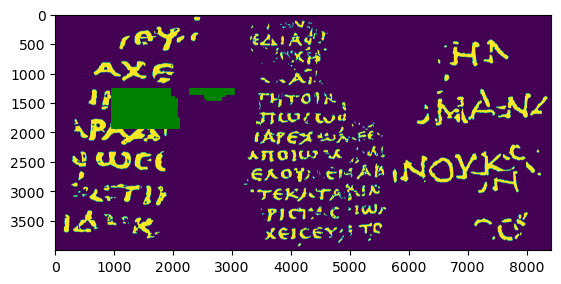

In [31]:
fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in val_locations_ds:
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(patch)
plt.show()

In [32]:
def trivial_baseline(dataset):
    """
    Calculates the trivial baseline accuracy for a given dataset.

    Args:
    - dataset: tf.data.Dataset object consisting of (image, label) pairs

    Returns:
    - The trivial baseline accuracy, calculated as 1 - (total positive labels / total labels)

    """
    total = 0
    matches = 0.
    for _, batch_label in tqdm(dataset):
        matches += tf.reduce_sum(tf.cast(batch_label, "float32"))
        total += tf.reduce_prod(tf.shape(batch_label))
    return 1. - matches / tf.cast(total, "float32")

In [33]:
score = trivial_baseline(val_ds).numpy()
print(f"Best validation score achievable trivially: {score * 100:.2f}% accuracy")

21it [00:03,  6.73it/s]

Best validation score achievable trivially: 76.03% accuracy


In [34]:
augmenter = keras.Sequential([
    layers.RandomContrast(0.2),
])

In [35]:
def augment_train_data(data, label):
    """
    Applies data augmentation to the training data and returns the augmented data and the original label.

    Args:
        data: A tensor representing the input data.
        label: A tensor representing the input label.

    Returns:
        The augmented data tensor and the original label tensor.
    """
    data = augmenter(data)
    return data, label

In [36]:
augmented_train_ds = train_ds.map(augment_train_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [37]:
def get_model(input_shape):
    """
    Builds a U-Net model with separable convolutions and residual connections.

    Args:
        input_shape: Tuple representing the shape of the input tensor.

    Returns:
        A Keras Model object representing the U-Net model.
    """
    inputs = keras.Input(input_shape)
    
    x = inputs
    
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [38]:
if USE_MIXED_PRECISION:
    keras.mixed_precision.set_global_policy('mixed_float16')

model = get_model((BUFFER * 2, BUFFER * 2, Z_DIM))
model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"], jit_compile=USE_JIT_COMPILE)

model.fit(augmented_train_ds, validation_data=val_ds, epochs=20, steps_per_epoch=1000)
model.save("model.keras")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 20)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   11584       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [39]:
del volume
del mask
del labels
del train_ds
del val_ds

# Manually trigger garbage collection
keras.backend.clear_session()
import gc
gc.collect()

model = keras.models.load_model("model.keras")

In [40]:
def compute_predictions_map(split, index):
    """
    Compute the predictions map for a given split and index.

    Args:
    - split (str): The split of the data (train, val or test).
    - index (int): The index of the volume to load.

    Returns:
    - predictions_map (numpy.ndarray): A 3D numpy array containing the predictions map.

    """
    print(f"Load data for {split}/{index}")

    # Load the volume and the mask for the given split and index
    test_volume = load_volume(split=split, index=index)
    test_mask = load_mask(split=split, index=index)

    # Create a list of test locations within the mask
    test_locations = []
    stride = BUFFER // 2
    for x in range(BUFFER, test_volume.shape[0] - BUFFER, stride):
        for y in range(BUFFER, test_volume.shape[1] - BUFFER, stride):
            test_locations.append((x, y))

    print(f"{len(test_locations)} test locations (before filtering by mask)")

    # Define functions to extract subvolumes and filter by mask
    sample_random_location_test = lambda x: sample_random_location(test_mask.shape)
    is_in_mask_test = lambda x: is_in_masked_zone(x, test_mask)
    extract_subvolume_test = lambda x: extract_subvolume(x, test_volume)

    # Create a dataset of test locations filtered by mask and map the extract_subvolume function to it
    test_locations_ds = tf.data.Dataset.from_tensor_slices(test_locations).filter(is_in_mask_test)
    test_ds = test_locations_ds.map(extract_subvolume_test, num_parallel_calls=tf.data.AUTOTUNE)

    # Initialize predictions map and counts
    predictions_map = np.zeros(test_volume.shape[:2] + (1,), dtype="float16")
    predictions_map_counts = np.zeros(test_volume.shape[:2] + (1,), dtype="int8")

    print(f"Compute predictions")

    # Generate predictions and update the predictions map
    for loc_batch, patch_batch in tqdm(zip(test_locations_ds.batch(BATCH_SIZE), test_ds.batch(BATCH_SIZE))):
        predictions = model.predict_on_batch(patch_batch)
        for (x, y), pred in zip(loc_batch, predictions):
            predictions_map[x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :] += pred
            predictions_map_counts[x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :] += 1  
    predictions_map /= (predictions_map_counts + 1e-7)
    return predictions_map

In [41]:
predictions_map_a = compute_predictions_map(split="test", index="a")
predictions_map_b = compute_predictions_map(split="test", index="b")

Load data for test/a


20it [00:16,  1.21it/s]


141942 test locations (before filtering by mask)
Compute predictions


2817it [03:55, 11.98it/s]


Load data for test/b


20it [00:27,  1.35s/it]


70602 test locations (before filtering by mask)
Compute predictions


1196it [01:42, 11.68it/s]


In [42]:
from skimage.transform import resize as resize_ski

original_size_a = Image.open(DATA_DIR + "/test/a/mask.png").size
predictions_map_a = resize_ski(predictions_map_a, original_size_a).squeeze()

original_size_b = Image.open(DATA_DIR + "/test/b/mask.png").size
predictions_map_b = resize_ski(predictions_map_b, original_size_b).squeeze()

In [43]:
def rle(predictions_map, threshold):
    """
    Computes the run-length encoding (RLE) of the binary mask defined by the predictions map.

    Args:
        predictions_map (ndarray): The predictions map to encode.
        threshold (float): The threshold value used to convert the predictions map to a binary mask.

    Returns:
        str: The RLE encoded binary mask.
    """
    flat_img = predictions_map.flatten()
    flat_img = np.where(flat_img > threshold, 1, 0).astype(np.uint8)

    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

In [44]:
threshold = 0.5

rle_a = rle(predictions_map_a, threshold=threshold)
rle_b = rle(predictions_map_b, threshold=threshold)
print("Id,Predicted\na," + rle_a + "\nb," + rle_b, file=open('submission.csv', 'w'))